In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)



100%|██████████| 182M/182M [00:50<00:00, 3.58MB/s]
100%|██████████| 64.3M/64.3M [00:32<00:00, 1.97MB/s]


In [3]:
class JustCNN(nn.Module):
    def __init__(self):
        super(JustCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 2 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 512 * 4 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [5]:
def train_model(model, trainloader, optimizer, criterion, epochs=15):
    model.to(device)
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(trainloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        losses.append(epoch_loss/len(trainloader))
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {losses[-1]:.4f} Train Acc: {correct/total:.4f}")
    return losses


In [6]:
def validate_model(model, valloader):
    model.eval()
    all_labels = []
    all_preds = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    acc = correct / total
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    roc_auc = roc_auc_score(all_labels, F.one_hot(torch.tensor(all_preds), num_classes=10).numpy(), multi_class="ovr")
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10,8))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Validation Accuracy per Class (Confusion Matrix)")
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)])
    print("Classification Report:\n", report)

    return acc, roc_auc, cm, report



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/15] Loss: 1.1300 Train Acc: 0.6104


Epoch [2/15] Loss: 0.4062 Train Acc: 0.8768


Epoch [3/15] Loss: 0.3092 Train Acc: 0.9067


Epoch [4/15] Loss: 0.2543 Train Acc: 0.9240


Epoch [5/15] Loss: 0.2104 Train Acc: 0.9388


Epoch [6/15] Loss: 0.1722 Train Acc: 0.9497


Epoch [7/15] Loss: 0.1482 Train Acc: 0.9558


Epoch [8/15] Loss: 0.1190 Train Acc: 0.9641


Epoch [9/15] Loss: 0.1031 Train Acc: 0.9689


Epoch [10/15] Loss: 0.0866 Train Acc: 0.9734


Epoch [11/15] Loss: 0.0771 Train Acc: 0.9764


Epoch [12/15] Loss: 0.0662 Train Acc: 0.9798


Epoch [13/15] Loss: 0.0635 Train Acc: 0.9804


Epoch [14/15] Loss: 0.0561 Train Acc: 0.9823


Epoch [15/15] Loss: 0.0471 Train Acc: 0.9855


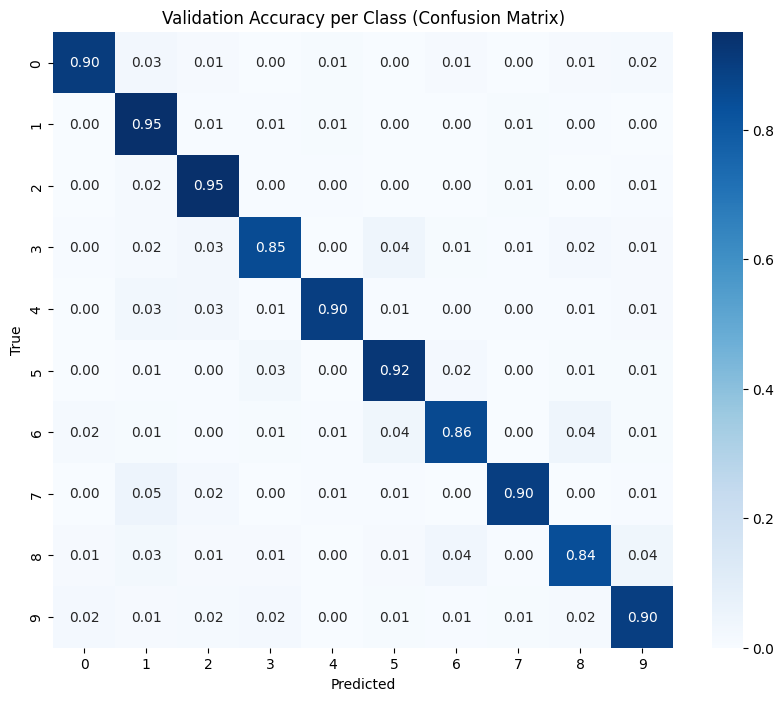

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       984
           1       0.91      0.95      0.93      2803
           2       0.92      0.95      0.93      2093
           3       0.93      0.85      0.89      1729
           4       0.95      0.90      0.92      1537
           5       0.88      0.92      0.90      1337
           6       0.90      0.86      0.88      1152
           7       0.92      0.90      0.91      1108
           8       0.84      0.84      0.84      1000
           9       0.84      0.90      0.87       909

    accuracy                           0.91     14652
   macro avg       0.90      0.90      0.90     14652
weighted avg       0.91      0.91      0.91     14652



In [9]:
model1 = JustCNN()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model1, trainloader, optimizer1, criterion, epochs=15)
acc1, roc_auc1, cm1, report1 = validate_model(model1, valloader)
